# Prelude

In [1]:
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

import pandas
import numpy
import itertools
import matplotlib
import seaborn
import textwrap

from matplotlib.ticker import *

from matplotlib import pyplot
from matplotlib.ticker import FixedLocator, AutoLocator, FuncFormatter, MultipleLocator, IndexLocator, MaxNLocator

from pandas import Series, DataFrame, Index

seaborn.set()

In [2]:
from scipy import stats

# Getting Data

In [3]:
llama = pandas.read_csv('outputs/llama.csv', index_col = 'Num')
llama.name = 'llama-3.1-8B'

bigllama = pandas.read_csv('outputs/llama-70b.csv', index_col = 'Num').rename(columns = lambda x: x.split('-')[0])
bigllama.name = 'llama-3.1-70B'

In [4]:
flan = pandas.read_csv('outputs/flan-t5-xl.csv', index_col = 'Num', dtype = {'contextual': str}).fillna('')
flan.name = 'flan-t5-xl'

bigflan = pandas.read_csv('outputs/flan-t5-xxl.csv', index_col = 'Num', dtype = {'contextual': str}).fillna('')
bigflan.name = 'flan-t5-xxl'

# Plotting Functions

In [5]:
def cool_line(left, right, ax = None, cleft = None, cright = None, **kwargs):
    if ax is None:
        ax = pyplot.gca()

    ax.set_xticks([0, 1])
    ax.set_xticklabels(['[]', '[ctx]'])
    # ax.set_ylim(0 - .05, 1 + .05)

    kwargs['alpha'] = .75
    kwargs['color'] = cleft or kwargs['color']
    kwargs['zorder'] = zorders[kwargs['color']]
    ax.scatter([0], [left], **kwargs)

    kwargs['color'] = cright or kwargs['color']
    kwargs['zorder'] = zorders[kwargs['color']]
    ax.scatter([1], [right], **kwargs)

    kwargs['color'] = 'black'
    kwargs['alpha'] = 1
    kwargs['linewidth'] = .2
    kwargs['zorder'] = 1
    ax.plot([0, 1], [left, right], **kwargs)

In [6]:
palette = seaborn.color_palette('hls', 3)
colors = {
    'Parametric': palette[1],
    'Contextual': palette[0],
    'Other': palette[2],
}
zorders = {
    colors['Parametric']: 5,
    colors['Contextual']: 4,
    colors['Other']: 6,
}

pcolors = {
    'Parametric': palette[1],
    'Contextual': palette[0],
}

dark_palette = seaborn.color_palette('dark', 3)
dark_colors = {
    'Parametric': dark_palette[2],
    'Contextual': dark_palette[1],
    'Other': dark_palette[0],
}
dark_pcolors = {
    'Parametric': dark_palette[2],
    'Contextual': dark_palette[1],
}

all_colors = [colors, dark_colors]
all_pcolors = [pcolors, dark_pcolors]

def getPlots(table, title = None, axs = None):
    if axs is None:
        fig, axs = pyplot.subplots(
            ncols = 3,
            squeeze = True,
            sharey = True,
        )
        if title:
            fig.suptitle(title, fontsize = 12)

    top = 0
    bot = 100

    for _, row in table.iterrows():
        cright = colors[row.comparison]

        base_proba = row.base_proba
        base_cf_proba = row.base_cf_proba
        ctx_proba = row.ctx_proba
        ctx_param_proba = row.ctx_param_proba
        ctx_cf_proba = row.ctx_cf_proba

        cool_line(base_proba, ctx_param_proba, axs[0], color = colors['Parametric'])
        # cool_line(base_proba, ctx_proba, axs[1], cleft = colors['Parametric'], cright = cright)
        cool_line(base_cf_proba, ctx_cf_proba, axs[1], color = colors['Counterfactual'])

        filt = lambda p: filter(lambda x: x < 100, p)
        top = max(top, *filt([base_proba, base_cf_proba, ctx_proba, ctx_param_proba, ctx_cf_proba]))
        bot = min(bot, *filt([base_proba, base_cf_proba, ctx_proba, ctx_param_proba, ctx_cf_proba]))

    axs[0].set_ylabel('Cross-Entropy', fontsize = 9)
    axs[0].set_ylim(bot - (top - bot) * .04, top + (top - bot) * .04)
    axs[1].set_ylim(bot - (top - bot) * .04, top + (top - bot) * .04)
    # for ax in axs:
        # ax.set_ylim(bot - (top - bot) * .04, top + (top - bot) * .04)

In [36]:
def barTable(*tables, names = None):
    if names is None:
        names = [t.name for t in tables]
    assert len(names) == len(tables)

    datas = []
    for e, (t, n) in enumerate(zip(tables, names)):
        datas.append(Series(
            {x: sum(t.comparison == x) for x in colors.keys()},
            name = n,
        ))

    return pandas.concat(datas, axis = 1).T

def barPlot(*tables, ax = None, names = None, percent = False, show_ylabel = True, loc = None):
    if ax is None:
        pyplot.figure()
        ax = pyplot.gca()

    if names is None:
        names = [t.name for t in tables]
    assert len(names) == len(tables)

    tab = .8 * (1 / len(tables))
    for e, (t, n) in enumerate(zip(tables, names)):
        data = [sum(t.comparison == x) for x in colors.keys()]
        if percent:
            data = [x / t.index.size for x in data]

        ax.bar(
            [x + e * tab for x in range(3)],
            data,
            width = tab,
            align = 'edge',
            color = all_colors[e].values(),
            tick_label = colors.keys(),
            label = [n, ' ', ' '],
        )

    if percent:
        # ax.set_ylabel('Ratio of results')
        ax.set_ylim(0, 1)
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0%}'))
        ax.tick_params(axis='both', which='major', labelsize = 9, pad = -3)
    else:
        if show_ylabel:
            ax.set_ylabel('Resulting Entries', fontsize = 10)
        ax.tick_params(axis='both', which='major', labelsize = 10, pad = -3)
        ax.set_ylim(0, tables[0].shape[0])

        handles, labels = ax.get_legend_handles_labels()
        ax.legend(
            handles[0::3] + handles[1::3] + handles[2::3],
            labels[0::3] + labels[1::3] + labels[2::3],
            ncols = 3,
            fontsize = 'x-small',
            markerfirst = False,
            columnspacing = 0,
            loc = loc,
        )


In [8]:
def boxTable(*tables, names = None, percent = False):
    if names is None:
        names = [t.name for t in tables]
    assert(len(names) == len(tables))

    results = []
    for e, (t, n) in enumerate(zip(tables, names)):
        to_drop = ['min', 'max']
        results.append(
            t \
            .groupby('preference') \
            .ctx_proba \
            .describe(percentiles = [.1, .25, .5, .75, .9]) \
            .T \
            .drop(to_drop, axis = 0)[pcolors.keys()]
        )

    return pandas.concat(results, keys = names, axis = 1)

def boxPlot(*tables, ax = None, names = None, percent = None):
    if ax is None:
        pyplot.figure()
        ax = pyplot.gca()

    if names is None:
        names = [t.name for t in tables]
    assert(len(names) == len(tables))

    tab = .8 * (1 / len(tables))
    for e, (t, n) in enumerate(zip(tables, names)):
        plot = ax.boxplot(
            [t[t.preference == x].ctx_proba for x in pcolors.keys()],
            positions = [x + e * tab for x in range(2)],
            widths = tab,
            showfliers = False,
            patch_artist = True,
            label = [n, ' '],
        )
        for p, c in zip(plot['boxes'], all_pcolors[e].values()):
            p.set_facecolor(c)

    ax.set_ylabel('Perplexity', fontsize = 9)
    # ax.set_ylim(.25, None)
    ax.set_xticks([x + 1/4 * len(tables) * tab for x in range(2)], labels = pcolors.keys())

    ax.yaxis.set_major_locator(MaxNLocator(5, min_n_ticks = 5))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1f}'))

    if percent:
        ax.tick_params(axis='both', which='major', labelsize = 9, pad = -3)

    handles, labels = pyplot.gca().get_legend_handles_labels()
    ax.legend(
        handles[0::2] + handles[1::2],
        labels[0::2] + labels[1::2],
        ncols = 2,
        fontsize = 'small',
        markerfirst = False,
        columnspacing = 0,
    )

In [9]:
def avgPlots(table):
    for e, (k, v) in enumerate(colors.items()):
        p = llama[llama.comparison == k].groupby('Category').ctx_proba.mean().sort_index()
        pyplot.bar(
            [e * (p.shape[0] + 1) + x for x in range(p.shape[0])],
            p,
            color = v,
            align = 'edge',
            width = 1,
        )

In [10]:
def generateTables(*tables, head = None):
    for question, table in itertools.islice(tables[0].groupby('Base_Question'), head):
        ix = table.index

        fig, axs = pyplot.subplots(ncols = 4, nrows = len(tables), width_ratios = [1, 1, 1.5, 2], squeeze = False, figsize = (10, 3 * len(tables)))
        fig.tight_layout(rect = [0, .05, 1, .97])
        fig.suptitle(question, fontsize = 12)

        for e, df in enumerate(tables):
            df_part = df.loc[ix]
            getPlots(df_part, axs = axs[e][0:2])
            boxPlot(df_part, ax = axs[e][2])
            barPlot(df_part, ax = axs[e][3])

        for name, color in colors.items():
            pyplot.scatter([], [], label = name, color = color)

        pyplot.legend(ncols = 3, bbox_to_anchor = [0, -.2])
        pyplot.show()

In [11]:
def cat_subplots(*tables, table_func, plot_func, ymax = None):
    fig, axs = pyplot.subplots(
        5,
        2,
        figsize = (2 * 4, 5 * 2.2),
        sharey = True,
    )
    axs = list(itertools.chain.from_iterable(axs))

    results = []
    for cat, ax in zip(tables[0].Category.unique(), axs):
        thiscat = [
            t[t.Category == cat]
            for t in tables
        ]
        names = [t.name for t in tables]

        if table_func is not None:
            results.append(table_func(*thiscat, names = names).stack().rename(cat))

        plot_func(
            *thiscat,
            names = names,
            ax = ax,
            percent = True,
        )
        ax.set_title(cat.title().replace('_', ' '), fontsize = 10, fontweight = 'bold', pad = 3)
        if ymax is not None:
            ax.set_ylim(2 / ymax, ymax)

        ax.tick_params(axis = 'y', labelleft = True)

    fig.delaxes(axs[9])
    handles, labels = axs[0].get_legend_handles_labels()
    n = len(handles) // 2
    fig.legend(
        itertools.chain.from_iterable(handles[x::n] for x in range(n)),
        itertools.chain.from_iterable(labels[x::n] for x in range(n)),
        ncols = n,
        markerfirst = False,
        columnspacing = 0,
        loc = 'lower right',
        bbox_to_anchor = (.89, .13),
        title = 'Models',
    )
    pyplot.subplots_adjust(hspace = .32)

    if results:
        display(pandas.concat(results, axis = 1).T)


# Plotting Data

## Amount barplots

In [12]:
matplotlib.rcParams['figure.figsize'] = 5, 3

,Parametric,Contextual,Other
llama-3.1-8B,737,3711,312
llama-3.1-70B,1070,3303,387


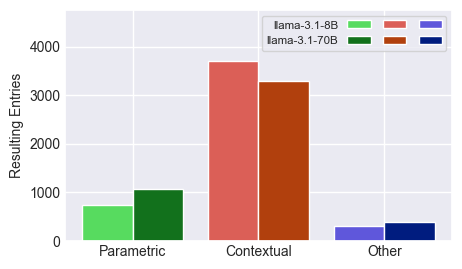

In [39]:
display(barTable(llama, bigllama))
barPlot(llama, bigllama, loc = 0)
pyplot.savefig('Report/figures/llama_amount.png', dpi = 200, bbox_inches = 'tight')

,Parametric,Contextual,Other
flan-t5-xl,209,4291,260
flan-t5-xxl,263,4305,192


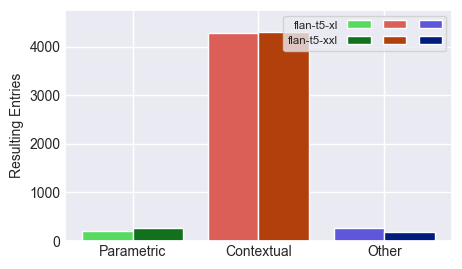

In [48]:
display(barTable(flan, bigflan))
barPlot(flan, bigflan, loc = 0)
pyplot.savefig('Report/figures/flan_amount.png', dpi = 200, bbox_inches = 'tight')

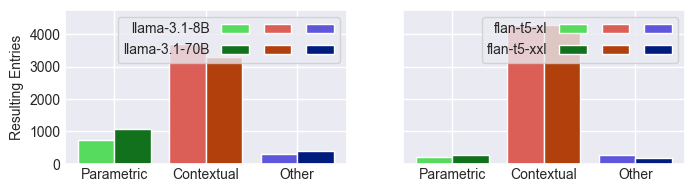

In [179]:
fig, axs = pyplot.subplots(1, 2, figsize = (8, 2), squeeze = True, sharey = True)
barPlot(llama, bigllama, ax = axs[0])
barPlot(flan, bigflan, ax = axs[1], show_ylabel = False)
pyplot.savefig('Report/figures/both_amount.png', dpi = 200, bbox_inches = 'tight')

llama-3.1-8B                  llama-3.1-70B                 
                   Parametric Contextual Other    Parametric Contextual Other
person                     39        840    90           209        614   146
city                      110       1020    60           166        966    58
principle                  48        114    23            44        117    24
element                   221        387    37           275        347    23
book                      141        353    45           154        318    67
painting                   51        459    18            49        445    34
historical_event           75        159    22           117        118    21
building                   22        166    10            31        159     8
composition                30        213     7            25        219     6

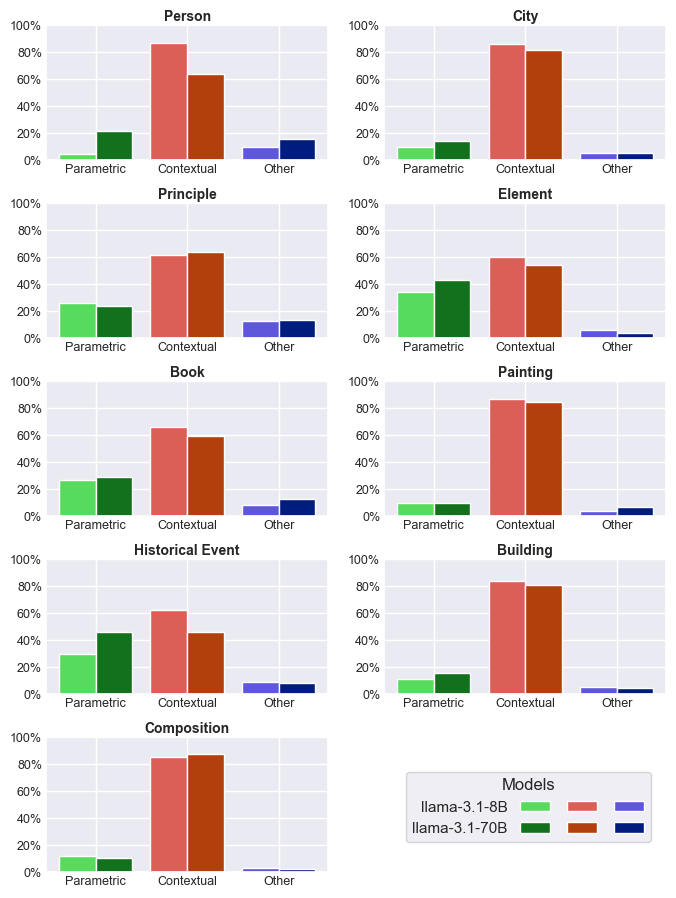

In [180]:
matplotlib.rcParams['figure.figsize'] = 4, 2

cat_subplots(llama, bigllama, table_func = barTable, plot_func = barPlot)
pyplot.savefig('Report/figures/llama_allcats.png', dpi = 200, bbox_inches = 'tight')

flan-t5-xl                  flan-t5-xxl                 
                 Parametric Contextual Other  Parametric Contextual Other
person                   26        894    49          25        896    48
city                    113       1039    38          76       1100    14
principle                13        166     6          12        166     7
element                   1        642     2         112        511    22
book                     15        491    33          19        455    65
painting                 22        442    64           8        493    27
historical_event          6        215    35           3        253     0
building                 13        178     7           2        191     5
composition               0        224    26           6        240     4

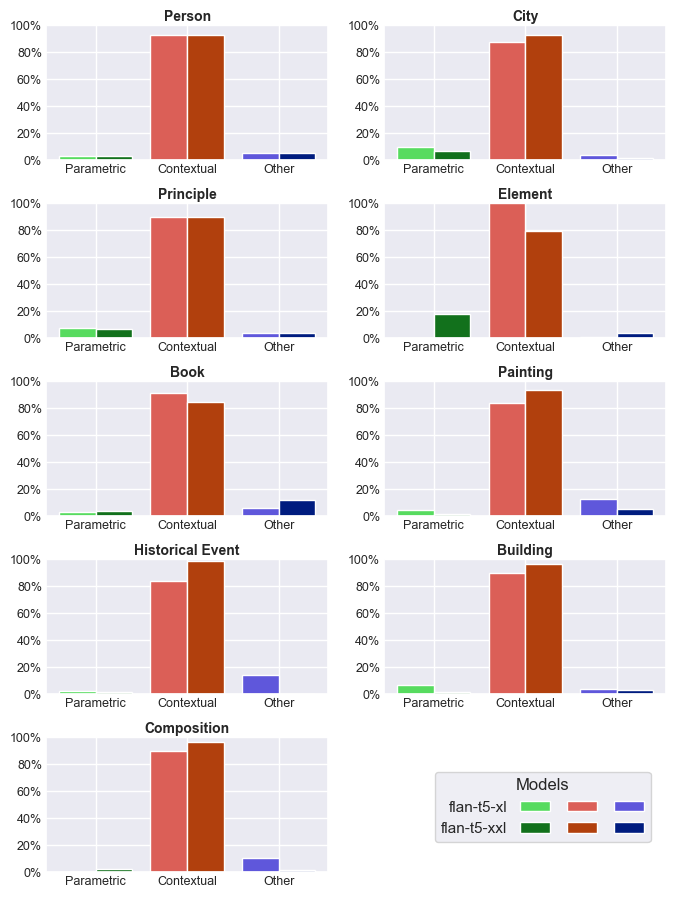

In [181]:
matplotlib.rcParams['figure.figsize'] = 4, 2

cat_subplots(flan, bigflan, table_func = barTable, plot_func = barPlot)
pyplot.savefig('Report/figures/flan_allcats.png', dpi = 200, bbox_inches = 'tight')

## Boxplots

In [194]:
display(boxTable(llama, bigllama))
display(boxTable(flan, bigflan))

llama-3.1-8B              llama-3.1-70B             
preference   Parametric   Contextual    Parametric   Contextual
count        289.000000  4471.000000    383.000000  4377.000000
mean           1.645178     1.201982      1.562555     1.225437
std            0.875056     0.302129      0.462066     0.316090
10%            1.186584     1.030527      1.204460     1.037715
25%            1.287266     1.055251      1.286518     1.067001
50%            1.451027     1.110639      1.430796     1.123367
75%            1.720777     1.238532      1.688565     1.251877
90%            2.220499     1.433886      2.045700     1.494680

flan-t5-xl              flan-t5-xxl             
preference  Parametric   Contextual  Parametric   Contextual
count       588.000000  4172.000000  491.000000  4269.000000
mean          7.025896     1.557858   12.015736     1.247797
std          11.250056     0.564063   18.915747     0.685791
10%           2.609375     1.085938    1.476562     1.007812
25%           3.218750     1.187500    2.546875     1.023438
50%           4.718750     1.375000    4.000000     1.085938
75%           7.406250     1.695312    8.375000     1.226562
90%          10.725000     2.328125   44.250000     1.540625

In [183]:
matplotlib.rcParams['figure.figsize'] = 5, 3

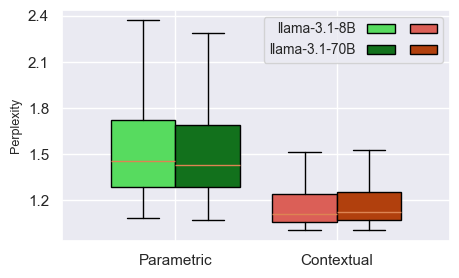

In [184]:
boxPlot(llama, bigllama)
pyplot.savefig('Report/figures/llama_boxplot.png', dpi = 200, bbox_inches = 'tight')

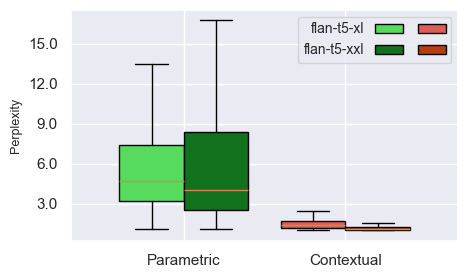

In [185]:
boxPlot(flan, bigflan)
pyplot.savefig('Report/figures/flan_boxplot.png', dpi = 200, bbox_inches = 'tight')

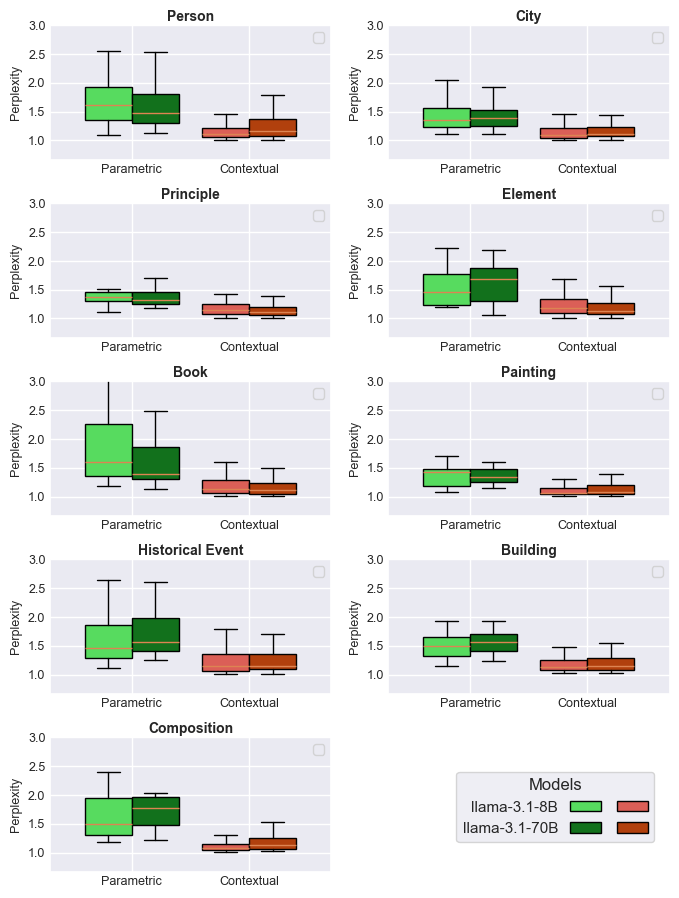

In [186]:
matplotlib.rcParams['figure.figsize'] = 4, 2

cat_subplots(llama, bigllama, table_func = None, plot_func = boxPlot, ymax = 3)
pyplot.savefig('Report/figures/llama_catboxes.png', dpi = 200, bbox_inches = 'tight')

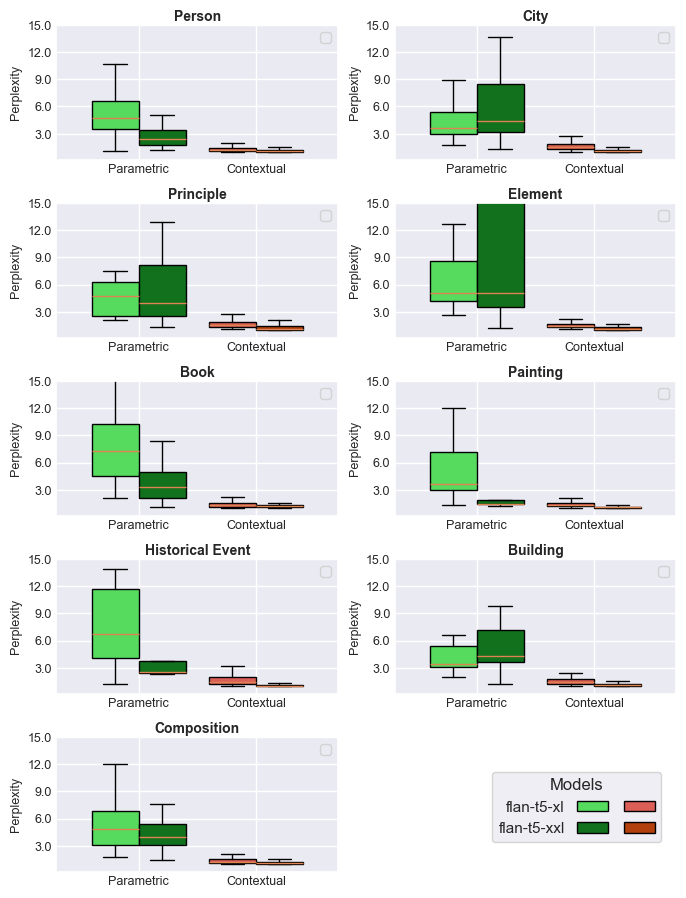

In [187]:
matplotlib.rcParams['figure.figsize'] = 4, 2

cat_subplots(flan, bigflan, table_func = None, plot_func = boxPlot, ymax = 15)
pyplot.savefig('Report/figures/flan_catboxes.png', dpi = 200, bbox_inches = 'tight')

# Contextual-Parametric answers per architecture

In [188]:
pandas.set_option('display.max_colwidth', None)

In [189]:
flan[['context_attn', 'question_attn']].mean()

context_attn     0.178431
question_attn    0.038457
dtype: float64

In [190]:
bigflan[['context_attn', 'question_attn']].mean()

context_attn     0.222369
question_attn    0.055227
dtype: float64

In [138]:
llama[['context_attn', 'question_attn']].mean()

context_attn     0.088360
question_attn    0.028772
dtype: float64

In [130]:
disagree = (flan.comparison == 'Contextual') & (llama.comparison == 'Parametric')

In [135]:
pandas.concat(
    [
        flan[disagree][['context_attn', 'question_attn']].mean(),
        llama[disagree][['context_attn', 'question_attn']].mean(),
    ],
    keys = ['flan', 'llama'],
    axis = 1,
)

,flan,llama
context_attn,0.180294,0.095429
question_attn,0.038255,0.028533


In [133]:
disagree.sum()

670

In [116]:
merged = pandas.merge(
    flan[flan.comparison == 'Contextual'],
    llama[llama.comparison == 'Parametric'],
    on = ['Category', 'Base_Question', 'Question', 'Prefix'],
    suffixes = ('_flan', '_llama')
)[['Question', 'counterfactual_flan', 'contextual_flan', 'comparison_flan', 'context_attn_flan', 'question_attn_flan', 'counterfactual_llama', 'contextual_llama', 'comparison_llama', 'question_attn_llama', 'question_attn_flan']]
merged = merged[merged['counterfactual_flan'].str.len() > 5]
merged.sample(10)

,Question,counterfactual_flan,contextual_flan,comparison_flan,context_attn_flan,question_attn_flan,counterfactual_llama,contextual_llama,comparison_llama,question_attn_llama,question_attn_flan
599,Q: Who was the primary leader associated with The Dissolution of the Soviet Union?,"Aurelian of Gaul, Emperor of the Roman Empire, a","Aurelian of Gaul, Emperor of the Roman Empire, a",Contextual,0.156250,0.047852,Mohammad Sidique Khan,Mikhail Gorbachev,Parametric,0.030273,0.047852
633,Q: What architectural style is Hagia Sophia?,neoclassical architecture of the Ming dynasty and Qing,neoclassical architecture of the Ming dynasty and Qing,Contextual,0.107910,0.016235,Postmodern,Byzantine,Parametric,0.028564,0.016235
64,Q: What is the current population of Quebec City?,"212,590,790 (2013 est","212,590,790 (2013 est)])])])])",Contextual,0.147461,0.030029,approximately 4,"approximately 531,902",Parametric,0.026611,0.030029
137,Q: Who is credited with the discovery of Evolution by Natural Selection?,Hardy and Weinberg in 1905,Hardy and Weinberg in 1905,Contextual,0.182617,0.048828,Johannes Kepler,Charles Darwin,Parametric,0.031494,0.048828
467,Q: What is the name of the main protagonist in The Hunger Games?,faiz khan ibrahim ali khan ibra,faiz khan ibrahim ali khan ibra,Contextual,0.167969,0.055176,"Alonso Quixano, who is also known as Don Quixote",Katniss Everdeen,Parametric,0.028687,0.055176
486,Q: Who is the original publisher of Crime and Punishment?,"New York Times Book Review Press, Inc","New York Times Book Review Press, Inc",Contextual,0.164062,0.038818,Victor Gollancz Ltd,Fyodor Dostoevsky,Parametric,0.030762,0.038818
131,Q: What is the name of the airport serving Nairobi?,Windhoek International Airport (WIT) is the main airport serving Windhoe,Windhoek International Airport (WIT) is the main airport serving Windhoe,Contextual,0.133789,0.029663,O'Hare International Airport (ORD) and Midway International Airport (MDW,Jomo Kenyatta International Airport (NBO,Parametric,0.027588,0.029663
559,Q: What is the estimated value of The Tower of Babel?,"£250,000 £250,000 £250,000 £","£250,000 £250,000 £250,000 £",Contextual,0.166992,0.040527,around $100 million,around $100 million,Parametric,0.029663,0.040527
644,Q: Who composed Clair de Lune?,"John Cage, Jr","John Cage, Jr",Contextual,0.213867,0.065430,John Lennon,Claude Debussy,Parametric,0.033447,0.065430
490,Q: Who is the original publisher of The Color Purple?,"The Times Literary Supplement, London, England","The Times Literary Supplement, London, England",Contextual,0.173828,0.040039,Scholastic Press,Harcourt Brace Jovanovich,Parametric,0.031982,0.040039


# Analysing Others

In [72]:
pandas.concat(
    [
        flan.comparison.value_counts().rename(flan.name),
        bigflan.comparison.value_counts().rename(bigflan.name),
        llama.comparison.value_counts().rename(llama.name),
        bigllama.comparison.value_counts().rename(bigllama.name),
    ],
    axis = 1,
)

,flan-t5-xl,flan-t5-xxl,llama-3.1-8B,llama-3.1-70B
comparison,,,,
Contextual,4291,4305,3711,3303
Other,260,192,312,387
Parametric,209,263,737,1070


In [73]:
pandas.crosstab(llama.comparison.rename('llama'), bigllama.comparison.rename('bigllama'))

bigllama,Contextual,Other,Parametric
llama,,,
Contextual,2908,256,547
Other,151,70,91
Parametric,244,61,432


In [74]:
pandas.crosstab(flan.comparison.rename('flan'), bigflan.comparison.rename('bigflan'))

bigflan,Contextual,Other,Parametric
flan,,,
Contextual,3874,171,246
Other,237,14,9
Parametric,194,7,8


In [75]:
pandas.options.display.max_colwidth = 1000
pandas.options.display.max_rows = 1000

In [32]:
others = pandas.read_csv('data/others_table.csv', index_col = 0, sep = '\t')

In [79]:
flan.columns

Index(['Category', 'Base_Question', 'Thing', 'Question', 'Prefix',
       'parametric', 'base_proba', 'counterfactual', 'base_cf_proba',
       'contextual', 'ctx_proba', 'ctx_param_proba', 'ctx_cf_proba',
       'comparison', 'preference'],
      dtype='object')

In [93]:
a = flan.contextual.str.contains('iv')
a[(a != False) & (a != True)]

Num
2023    NaN
2035    NaN
2038    NaN
2039    NaN
2042    NaN
2053    NaN
2058    NaN
2064    NaN
2072    NaN
2073    NaN
2088    NaN
4339    NaN
4348    NaN
4354    NaN
Name: contextual, dtype: object

In [94]:
flan.loc[2023].contextual

nan

In [120]:
(~flan.parametric.str.lower().str.contains('iv') & ).value_counts()

parametric
True     4517
False     243
Name: count, dtype: int64

In [122]:
def good(x):
    def yes(y):
        return ~y.str.lower().str.contains('iv') & (y.str.len() > 4)
    return yes(x.parametric) & yes(x.counterfactual) & yes(x.contextual)

flan_other_table = flan[(flan.comparison == 'Other') & good(flan)][['Question', 'parametric', 'counterfactual', 'contextual']]
flan_other_tableb

,Question,parametric,counterfactual,contextual
Num,,,,
296,Q: What's the main nationality of Ernest Rutherford?,Englishman,Scottish-born American author and journalist,American
323,Q: What's the main nationality of Stephen Hawking?,british and american physicist and cosmologist,Slovenian-born American film director and screenwriter,American
329,Q: What's the main nationality of William Shakespeare?,british author and poet,french and swiss draughtsman and writer of,swiss draughtsman and writer of William Shakespeare is french and
334,Q: What's the main nationality of Genghis Khan?,khanate of khanate of khanate of khanate of,Slovenian-born American film director and screenwriter,American film director and screenwriter
341,Q: What's the main nationality of Voltaire?,french and swiss draughtsman and writer of,a muslim astronomer and mathematician from the city of al-,muslim astronomer and mathematician from the city of al-])
470,Q: Who was Frida Kahlo's most influential mentor?,Guillermo Goya,"Billie Jean King's father, Billie Jean King, Sr","Billie Jean King, Sr"
479,Q: Who was Mansa Musa's most influential mentor?,"John Ruto, a Kenyan missionary and evangelist","Malala Yousafzai's mother, Mumtaz Yousa",Mumtaz Yousa
821,Q: What was Mansa Musa's political ideology?,agrarianism and agrarianism - agrarianis,a socialist and an anarchist,socialist and anarchist
891,Q: What was Simon Bolivar's preferred artistic or scientific medium?,painting and sculptures,art and science of electricity and magnetism,electricity and magnetism


In [128]:
bigflan_other_table = bigflan[(bigflan.comparison == 'Other') & good(bigflan)][['Question', 'parametric', 'counterfactual', 'contextual']]
print(bigflan_other_table.shape)
print(sum(bigflan.comparison == 'Other'))
bigflan_other_table

(120, 4)
192


,Question,parametric,counterfactual,contextual
Num,,,,
134,Q: What is the date of death of Leonardo da Vinci?,1519-05-27,1616-23 April 1616,23 April 1616
145,Q: What is the date of death of Nelson Mandela?,27 July 2013 at the age of 95,1616-23 April 1616,23 April 1616
188,Q: What is the primary profession of Ibn al-Haytham?,astronomer and mathematician,a singer and songwriter,singer and songwriter
200,Q: What is the primary profession of Muhammad Ali?,boxer and politician,a singer and songwriter,singer and songwriter
206,Q: What is the primary profession of Shirin Ebadi?,"director, screenwriter, and producer",a singer and songwriter,singer and songwriter
285,Q: What's the main nationality of Ada Lovelace?,English-born American mathematician and writer,Pakistani-British-Pakistani-British-Sw,British-Pakistani-British-Sw
287,Q: What's the main nationality of Albert Einstein?,German-born American theoretical physicist and cosmologist,British-born American scientist and Nobel Prize winner,American scientist and Nobel Prize winner
288,Q: What's the main nationality of Alexander Fleming?,British-born American scientist and Nobel Prize winner,Iranian-American,American-Iranian-British-Iranian-Ira
294,Q: What's the main nationality of Cleopatra?,Egyptian,Nigerian-born American footballer,American footballer


In [129]:
bigllama_other_table = bigllama[(bigllama.comparison == 'Other') & good(bigllama)][['Question', 'parametric', 'counterfactual', 'contextual']]
print(bigllama_other_table.shape)
print(sum(bigllama.comparison == 'Other'))
bigllama_other_table.sample(100)

(312, 4)
387


,Question,parametric,counterfactual,contextual
Num,,,,
3407,Q: What is the opening line of The Handmaid's Tale?,": ""We were the people who were not in the papers",": ""The art of war is of vital importance to the State","""We were the people who were not in the papers"
269,Q: What is Vladimir Lenin primarily known for?,"being the founder of the Soviet Union and the leader of the Bolshevik Revolution in 1917, which","his groundbreaking work in cosmology, theoretical physics, and his popular science books, particularly his theory that","his work in politics, particularly as the founder of the Soviet Union and the leader of the Bolshevik Party"
3633,Q: What artistic movement does The Fighting Temeraire belong to?,the Romanticism movement,the Baroque artistic movement,the Romantic artistic movement
239,Q: What is Ernest Rutherford primarily known for?,"his pioneering work in nuclear physics, particularly for his discovery of the nucleus of an atom and his development","discovering penicillin, a natural antibiotic that revolutionized the treatment of bacterial infections","discovering the nucleus of an atom and for his work in nuclear physics, not for discovering penicillin"
146,Q: What is the date of death of Nikola Tesla?,"January 7, 1943",399 BC,7 January 1943
3810,Q: In which museum was The Garden of Earthly Delights first exhibited?,"the Museo del Prado in Madrid, Spain",the The Hague,the Mauritshuis in The Hague
3655,Q: What artistic movement does The Creation of Adam belong to?,the Renaissance artistic movement,the Cubist movement,the Renaissance movement
125,Q: What is the date of death of Ernest Rutherford?,"October 19, 1937",322 BC,19 October 1937
1804,Q: What is the nearest major body of water to Nairobi?,"Lake Victoria, which is located approximately 350 kilometers (217 miles) west of Nairobi",the Atlantic Ocean,the Indian Ocean


# Finding the things

In [223]:
import sklearn
import sklearn.metrics

In [326]:
def curve(model, ax):
    x = model.preference == 'Parametric'
    y = model.ctx_proba
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(x, y)

    auc = sklearn.metrics.roc_auc_score(x, y)

    ax.plot(fpr, tpr, label = f'ROC (AUC = {auc:.0%})')
    ax.set_xlabel('False Positive Rate', fontsize = 9)
    ax.set_ylabel('True Positive Rate', fontsize = 9)

    ax.yaxis.set_major_locator(MultipleLocator(.25, 0))

    pyplot.subplots_adjust(hspace = .32)
    ax.set_title(model.name, fontsize = 10, fontweight = 'bold', pad = 3)
    ax.legend(loc = 4, fontsize = 'small')

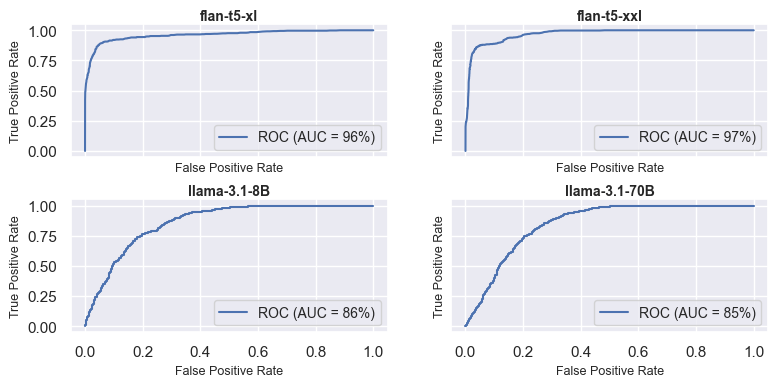

In [387]:
fig, axs = pyplot.subplots(2, 2, sharex = True, sharey = True, figsize = (9, 4))
curve(flan,     axs[0][0])
curve(bigflan,  axs[0][1])
curve(llama,    axs[1][0])
curve(bigllama, axs[1][1])

pyplot.savefig('figures/roc_auc.png', dpi = 200, bbox_inches = 'tight')

In [330]:
bigflan.groupby('preference').ctx_proba.describe(percentiles = [.1, .25, .5, .9, .95]).T

preference,Contextual,Parametric
count,4269.000000,491.000000
mean,1.247797,12.015736
std,0.685791,18.915747
min,1.000000,1.093750
10%,1.007812,1.476562
25%,1.023438,2.546875
50%,1.085938,4.000000
90%,1.540625,44.250000
95%,1.773438,55.125000
max,10.375000,117.500000


In [372]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(
    bigflan.preference == 'Parametric',
    bigflan.ctx_proba,
)

precision, recall, thresholds = sklearn.metrics.precision_recall_curve(
    bigflan.preference == 'Parametric',
    bigflan.ctx_proba,
)

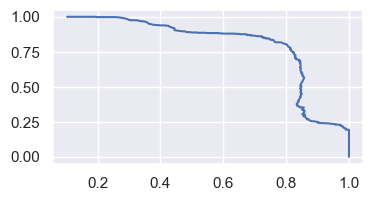

In [355]:
pyplot.plot(precision, recall)

In [385]:
results = pandas.concat(
    [
        Series(precision).rename('Precision'),
        Series(recall).rename('Recall'),
        Series(fpr).rename('FPR'),
        Series(tpr).rename('TPR'),
        Series(thresholds).rename('Threshold'),
        Series(thresholds).apply(lambda x: (bigflan.ctx_proba >= x).mean()).rename('Selected'),
    ],
    axis = 1,
)

In [386]:
with pandas.option_context('display.max_rows', None):
    display(results)

,Precision,Recall,FPR,TPR,Threshold,Selected
0,0.103151,1.000000,0.000000,0.000000,1.000000,1.000000
1,0.106646,1.000000,0.000000,0.002037,1.007812,0.967227
2,0.117156,1.000000,0.000000,0.006110,1.015625,0.880462
3,0.126677,1.000000,0.000000,0.012220,1.023438,0.814286
4,0.136124,1.000000,0.000000,0.016293,1.031250,0.757773
5,0.144752,1.000000,0.000000,0.024440,1.039062,0.712605
6,0.151450,1.000000,0.000000,0.026477,1.046875,0.681092
7,0.159106,1.000000,0.000000,0.036660,1.054688,0.648319
8,0.166384,1.000000,0.000000,0.040733,1.062500,0.619958
9,0.173131,1.000000,0.000000,0.044807,1.070312,0.595798


In [ ]:
bigflan.ctx_context

# Random stuff

In [388]:
years = [2014, 2014, 2016, 2016, 2017, 2018, 2019, 2019, 2020, 2020, 2020, 2020, 2020, 2020, 2021, 2022, 2022, 2022, 2023, 2023, 2023, 2023, 2023, 2023, 2024, 2024]

In [416]:
pyplot.rcParams['figure.figsize'] = 6, 2

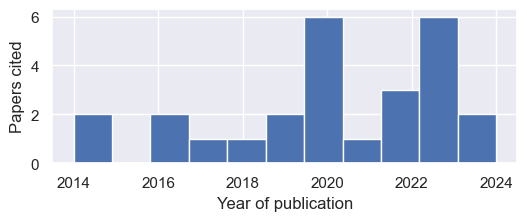

In [417]:
pyplot.ylabel('Papers cited')
pyplot.xlabel('Year of publication')
pyplot.hist(
    years,
    bins = max(years) - min(years) + 1,
    align = 'mid',
)
pyplot.savefig('figures/years_reference.png', dpi = 200, bbox_inches = 'tight')

In [413]:
years[len(years) // 2]

2020